In [1]:
import os #for accessing the file system of the system
import sys
import random
import numpy as np
import cv2 #computer vision lib for image processing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

seed = 2323; #seed values to create random values
random.seed = seed;
np.random.seed = seed;
tf.seed = seed;


In [2]:
class DataGen(keras.utils.Sequence):
    def __init__(self, train_ids, train_path, batch_size=10, image_size=128):
        self.ids = train_ids;
        self.path = train_path;
        self.batch_size = batch_size;
        self.image_size = image_size;
        self.on_epoch_end();
        
    def __load__(self, id_name):
        #defining path for the training data set
        image_path = os.path.join(self.path, "images", id_name);#polyp segmentation/images/id_name.jpg
        mask_path = os.path.join(self.path, "masks", id_name); #polyp segmenatation/masks/id_name.jpg
        
        # reading the image from dataset
        ## Reading Image
        image = cv2.imread(image_path, 1); #reading image to image vaiable
        image = cv2.resize(image, (self.image_size, self.image_size));# resizing input image to 128 * 128
        
        mask = cv2.imread(mask_path, 0); #mask image of same size with all zeros
        mask = cv2.resize(mask, (self.image_size ,self.image_size));# resizing mask to fit the 128 * 128 image
        mask = np.expand_dims(mask, axis=-1);
        #image normalisation
        image = image / 255.0;
        mask = mask / 255.0;
        
        return image, mask;
    
    def __getitem__(self, index): #index : batch no.
        
        if(index+1)*self.batch_size > len(self.ids): # redining last batch size
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size] #list of 10 image ids
        
        image = [] #collection of 10 images
        mask  = [] #collection of 10 masks
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name);
            image.append(_img);
            mask.append(_mask);
            
        image = np.array(image);
        mask  = np.array(mask);
        
        return image, mask; #return array of 10 images and 10 masks
    
    #for printing the statistics of the function
    def on_epoch_end(self):
        print("epoch completed");
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)));#length of the epoch as length of generation DataGen obj

In [3]:


#hyperparameter
image_size = 128;
train_path = "./Desktop/Kvasir-SEG/"; #address of the dataset
epochs = 3; #number of time we need to train dataset
batch_size = 10; #tarining batch size

#train path
train_ids = os.listdir(train_path + "/images")
#Validation Data Size
val_data_size = 10; #size of set of images used for the validation 

valid_ids = train_ids[:val_data_size]; # list of image ids used for validation of result 0 to 9
train_ids = train_ids[val_data_size:]; #list of image ids used for training dataset
#print(valid_ids, "\n\n");
print("training_size: ", len(train_ids), "validation_size: ", len(valid_ids))

#making generator object
gen = DataGen(train_ids, train_path, batch_size, image_size);
print("total epoch: ", len(gen))
#print(valid_ids)



training_size:  990 validation_size:  10
epoch completed
total epoch:  99


shape of the batch (10, 128, 128, 3) (10, 128, 128, 1)
Number of images in the batch:  10


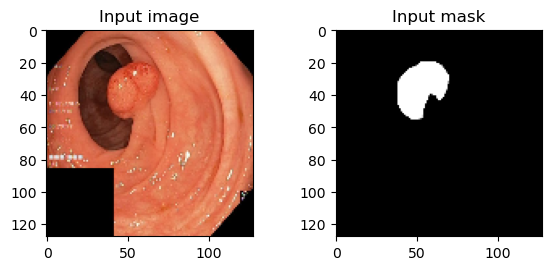

In [4]:
#Analysing sample of the dataset from data generator
#getting image_set data from dataset
x, y = gen.__getitem__(0); # self = gen and index = 0 each item is a set of 8 images
print("shape of the batch", x.shape, y.shape);
print("Number of images in the batch: ", len(x));

#display of the sample of the data zeroth image

fig = plt.figure();
fig.subplots_adjust(hspace=0.4, wspace=0.4); #reserving height above plot and space between plots
ax = fig.add_subplot(1, 2, 1); #figure of 1 row 2 columns and 1st image
x1 = (x[3]*255).astype(np.uint8);
x1 = cv2.cvtColor(x1, cv2.COLOR_BGR2RGB);
ax.imshow(x1);
plt.title("Input image");

ax = fig.add_subplot(1, 2, 2); #2nd image plot
ax.imshow(np.reshape(y[3], (image_size, image_size)), cmap="gray");
plt.title("Input mask");

In [5]:
#creating convolutional blocks

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x) # nearest interpolation
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [6]:
#unet model
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #pooling layer downsmaples 128*128 image to 64 * 64
    c2, p2 = down_block(p1, f[1]) #pooling layer downsmaples 128*128 image to 32 * 32
    c3, p3 = down_block(p2, f[2]) #pooling layer downsmaples 128*128 image to 16 * 16
    c4, p4 = down_block(p3, f[3]) #pooling layer downsmaples 128*128 image to 8 * 8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #upsampling layer upsmaples 8 * 8 image to 16 * 16
    u2 = up_block(u1, c3, f[2]) #upsampling layer upsmaples 8 * 8 image to 32 * 32
    u3 = up_block(u2, c2, f[1]) #upsampling layer upsmaples 8 * 8 image to 64 * 64
    u4 = up_block(u3, c1, f[0]) #upsampling layer upsmaples 8 * 8 image to 128 * 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [7]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)           0         ['conv2d_1[0][0]']            
 D)                                                                                        

 conv2d_18 (Conv2D)          (None, 128, 128, 1)          17        ['conv2d_17[0][0]']           
                                                                                                  
Total params: 1962625 (7.49 MB)
Trainable params: 1962625 (7.49 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


In [8]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size);
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size);
print("total training batches: ", len(train_gen));
print("total validaton batches: ", len(valid_gen));
train_steps = len(train_ids)//batch_size;
valid_steps = len(valid_ids)//batch_size;

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=10);

epoch completed
epoch completed
total training batches:  99
total validaton batches:  1
Epoch 1/10


C:\Users\dev\AppData\Local\Temp\ipykernel_5332\2453572847.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=10);




99/99 [==============================] - 22s 197ms/step - loss: 0.4433 - acc: 0.8392 - val_loss: 0.4086 - val_acc: 0.8120
epoch completed
Epoch 2/10
99/99 [==============================] - 19s 194ms/step - loss: 0.3607 - acc: 0.8403 - val_loss: 0.3653 - val_acc: 0.8120
epoch completed
Epoch 3/10
99/99 [==============================] - 21s 210ms/step - loss: 0.3413 - acc: 0.8403 - val_loss: 0.3634 - val_acc: 0.8120
epoch completed
Epoch 4/10
99/99 [==============================] - 22s 220ms/step - loss: 0.3205 - acc: 0.8523 - val_loss: 0.3413 - val_acc: 0.8373
epoch completed
Epoch 5/10
99/99 [==============================] - 21s 207ms/step - loss: 0.3208 - acc: 0.8541 - val_loss: 0.3583 - val_acc: 0.8192
epoch completed
Epoch 6/10
99/99 [==============================] - 21s 210ms/step - loss: 0.3150 - acc: 0.8572 - val_loss: 0.3229 - val_acc: 0.8319
epoch completed
Epoch 7/10
99/99 [==============================] - 22s 221ms/step - loss: 0.3009 - acc: 0.8679 - val_loss: 0.3751 

In [9]:
def size_classification(pi_mask):
    
  """
  Analyzes the polyp based on size for classification.

  Args:
      pi_mask: A binary mask representing the predicted polyp region.

  Returns:
      None (prints classification message to console).
  """
  # Based on size
  polyp_sizes = [1600, 2500]
  polyp_size = np.count_nonzero(pi_mask)

  if polyp_size == 0:
    print('No polyp detected! You are safe.')
  elif polyp_size < polyp_sizes[0]:
    print('Polyp size:', polyp_size, 'pixels. It is a low risk polyp of type 1. It has a 1% chance of becoming cancerous.')
  elif polyp_size < polyp_sizes[1]:
    print('Polyp size:', polyp_size, 'pixels. It is a medium risk polyp of type 2. It has a 10% chance of becoming cancerous.')
  else:
    print('Polyp size:', polyp_size, 'pixels. It is a high risk polyp of type 3. It has a 50% chance of becoming cancerous.')


In [10]:
# Save the Weights
#model.save_weights("UNet_polyp_weight_60_epoch.h5");
p_image, p_mask = train_gen.__getitem__(2); #accessed as normalised bool
print("shape of input image: ", p_image.shape, "shape of input mask: ", p_mask.shape)
result_mask = model.predict(p_image); #collection of 10 masks
print("result_mask shape: ", result_mask.shape);
predicted_mask = result_mask > 0.40; #float probability to bool conversion

shape of input image:  (10, 128, 128, 3) shape of input mask:  (10, 128, 128, 1)
1/1 [==============================] - 0s 249ms/step
result_mask shape:  (10, 128, 128, 1)


Polyp size: 2053 pixels. It is a medium risk polyp of type 2. It has a 10% chance of becoming cancerous.
Accuracy: 0.86907958984375
IOU of prediction =  0.13503674193983026


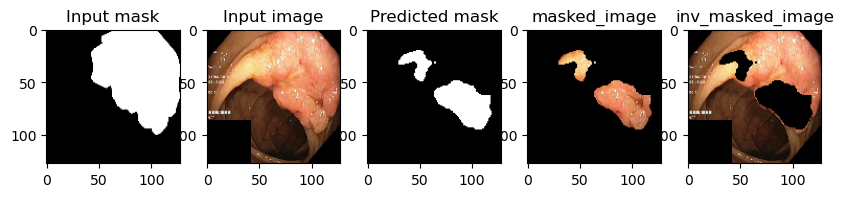

In [22]:
#Plotting the output
fig1 = plt.figure(figsize=(10, 10))
i = 4
fig1.subplots_adjust(hspace=.2, wspace=.2)
my_plot = fig1.add_subplot(1, 5, 1)
plt.title("Input mask")
pi_mask = np.reshape(p_mask[i]*255, (image_size, image_size))
my_plot.imshow(pi_mask, cmap="gray") #(128, 128, 1) -> (128, 128)
my_plot = fig1.add_subplot(1, 5, 2);
pr_image = p_image[i][:,:,::-1]
my_plot.imshow(pr_image);
plt.title("Input image")
masked_image = ((predicted_mask[i]*255) * pr_image).astype(int)

inverted_masked_image = (((1 - predicted_mask[i]) * 255) * pr_image).astype(int)
my_plot = fig1.add_subplot(1, 5, 3)
pred_mask = np.reshape(predicted_mask[i]*255, (image_size, image_size)) #(128, 128, 1) -> (128, 128)
my_plot.imshow(pred_mask, cmap="gray")
plt.title("Predicted mask")
my_plot = fig1.add_subplot(1, 5, 4)
my_plot.imshow(masked_image)
plt.title("masked_image")

my_plot = fig1.add_subplot(1, 5, 5)
my_plot.imshow(inverted_masked_image)
plt.title("inv_masked_image")
size_classification(pred_mask)

threshold = 0.8
binary_p_mask = (p_mask > threshold).astype(int)
binary_predicted_mask = predicted_mask.astype(int)

# # Calculate accuracy metrics
accuracy = accuracy_score(np.reshape(binary_p_mask, -1), np.reshape(binary_predicted_mask, -1))
# precision = precision_score(np.reshape(binary_p_mask, -1), np.reshape(binary_predicted_mask, -1))
# recall = recall_score(np.reshape(binary_p_mask, -1), np.reshape(binary_predicted_mask, -1))
# f1 = f1_score(np.reshape(binary_p_mask, -1), np.reshape(binary_predicted_mask, -1))

print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1)


# IOU calculation
# variables used will be p_mask and pred_mask
intersection = np.logical_and(p_mask, pred_mask)
union = np.logical_or(p_mask, pred_mask)
iou_score = np.sum(intersection) / np.sum(union)
print("IOU of prediction = ", iou_score)






